In [1]:
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import metrics
import os
import matplotlib.pyplot as plt

In [2]:
# For reproducible results
np.random.seed(0)

In [3]:
# Load the the csv file (Indian liver patient (Kaggle).csv)
LiverDisease_address = '/Users/francybayona/Documents/DOC DIEGO/Python docs/Nanostic Project/Indian liver patient (Kaggle).csv'
df_LiverDisease = pd.read_csv(LiverDisease_address)
df_LiverDisease.head(2)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Liver_Disease
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1


In [4]:
# Use the function LabelEncoder for the column Gender
# LabelEncoder transform the Gender values (Female and Male) to numerical values (0 y 1)
# Machine Leraning models work with numerical values
df_LiverDisease['Gender'] = LabelEncoder().fit_transform(df_LiverDisease['Gender'])
df_LiverDisease.head(2)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Liver_Disease
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1


In [5]:
df_LiverDisease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    int64  
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Liver_Disease               583 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 50.2 KB


In [6]:
# Fill NaN values for the Albumin_and_Globulin_Ratio column
df_LiverDisease_FillNaN = df_LiverDisease.fillna({'Albumin_and_Globulin_Ratio':df_LiverDisease['Albumin_and_Globulin_Ratio'].mean()})
df_LiverDisease_FillNaN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    int64  
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  583 non-null    float64
 10  Liver_Disease               583 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 50.2 KB


In [7]:
#Separate variables (x) from target (y) 
x = df_LiverDisease_FillNaN.drop(['Liver_Disease'],axis='columns')
#x = preprocessing.scale(variables)
y = df_LiverDisease_FillNaN.Liver_Disease

In [8]:
# Specify the number of folds for the outer cross validation
outer_cv_folds = 5

In [9]:
# Initialize probability variables for XGBoost
prob_train_XGBoost = np.full((np.shape(x)[0], outer_cv_folds), np.nan)
prob_test_XGBoost = np.full((np.shape(x)[0], outer_cv_folds), np.nan)
aucs_train_XGBoost = np.full(outer_cv_folds, np.nan)
aucs_test_XGBoost = np.full(outer_cv_folds, np.nan)

In [10]:
# Initialize probability variables for RandomForestClassifier
prob_train_RFC = np.full((np.shape(x)[0], outer_cv_folds), np.nan)
prob_test_RFC = np.full((np.shape(x)[0], outer_cv_folds), np.nan)
aucs_train_RFC = np.full(outer_cv_folds, np.nan)
aucs_test_RFC = np.full(outer_cv_folds, np.nan)

In [11]:
# Initialize probability variables for Suport Vector Machine
prob_train_SVM = np.full((np.shape(x)[0], outer_cv_folds), np.nan)
prob_test_SVM = np.full((np.shape(x)[0], outer_cv_folds), np.nan)
aucs_train_SVM  = np.full(outer_cv_folds, np.nan)
aucs_test_SVM  = np.full(outer_cv_folds, np.nan)

In [12]:
# Initialize probability variables for LogisticRegression
prob_train_LogR = np.full((np.shape(x)[0], outer_cv_folds), np.nan)
prob_test_LogR = np.full((np.shape(x)[0], outer_cv_folds), np.nan)
aucs_train_LogR = np.full(outer_cv_folds, np.nan)
aucs_test_LogR = np.full(outer_cv_folds, np.nan)

In [13]:
# Initialize probability variables for Single Decision Tree Classifier
prob_train_SDTree = np.full((np.shape(x)[0], outer_cv_folds), np.nan)
prob_test_SDTree = np.full((np.shape(x)[0], outer_cv_folds), np.nan)
aucs_train_SDTree = np.full(outer_cv_folds, np.nan)
aucs_test_SDTree = np.full(outer_cv_folds, np.nan)

In [14]:
#Outer cross validation
cv_outer = StratifiedKFold(n_splits=outer_cv_folds)
ncv_idx = -1

In [15]:
#Design a for loop for a inner cross validation
for train_idx, test_idx in cv_outer.split(x, y):
    ncv_idx += 1
    train_data, test_data = x.iloc[train_idx], x.iloc[test_idx]
    train_target, test_target = y.iloc[train_idx], y.iloc[test_idx]
    XGBoost_model = XGBClassifier(objective = 'binary:logistic', # Add objective and metric to model initialization
                                  eval_metric = 'auc')
    RFC_model = RandomForestClassifier()
    SVM_model = SVC(probability=True)
    LogR_model = LogisticRegression()
    SDTree_model = tree.DecisionTreeClassifier()
    # Find best XGBoost parameters
    cv_inner = StratifiedKFold(n_splits=3)   # Training data being split 3 times 
    Parmt_XGBoost = {'n_estimators':[50, 100],
                     'max_depth':[3, 5],
                     'learning_rate':[0.01, 0.1, 0.3],
                     'colsample_bytree':[0.5, 1],
                     'gamma':[0],
                     }
    
    Parmt_model_XGBoost = GridSearchCV(estimator=XGBoost_model,
                                       param_grid=Parmt_XGBoost,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       cv=cv_inner).fit(train_data,train_target)
    best_parameters_XGBoost = Parmt_model_XGBoost.best_params_
    # Set best parameters to XGBoost 
    XGBoost_model.set_params(**best_parameters_XGBoost)
    # Train optimized XGBoost model on train data
    XGBoost_model.fit(train_data,train_target)
    # Train data results
    prob_train_XGBoost[train_idx, ncv_idx] = XGBoost_model.predict_proba(train_data)[:,1]
    aucs_train_XGBoost[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_XGBoost[train_idx, ncv_idx])
    # Test data results
    prob_test_XGBoost[test_idx, ncv_idx] = XGBoost_model.predict_proba(test_data)[:,1]
    aucs_test_XGBoost[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_XGBoost[test_idx, ncv_idx])
    
    # Find best RandomForestClassifier parameters
    Parmt_RFC = {'criterion':['gini','entropy'], 'max_depth':[1,10,100,1000],
               'class_weight':['balanced',None]}
    Parmt_model_RFC = GridSearchCV(estimator=RFC_model,
                                       param_grid=Parmt_RFC,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       cv=cv_inner).fit(train_data,train_target)
    best_parameters_RFC = Parmt_model_RFC.best_params_
    # Set best parameters to RFC
    RFC_model.set_params(**best_parameters_RFC)
    # Train optimized RFC model on train data
    RFC_model.fit(train_data,train_target)
    # Train data results
    prob_train_RFC[train_idx, ncv_idx] = RFC_model.predict_proba(train_data)[:,1]
    aucs_train_RFC[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_RFC[train_idx, ncv_idx])
    # Test data results
    prob_test_RFC[test_idx, ncv_idx] = RFC_model.predict_proba(test_data)[:,1]
    aucs_test_RFC[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_RFC[test_idx, ncv_idx])
    
    # Find best Suport Vector Machine parameters
    Parmt_SVM = {'C':[1,10,100], 'class_weight':['balanced',None], 'coef0':[0,1,10],
             'decision_function_shape':['ovo','ovr'], 'gamma':['scale','auto'],
             'kernel':['rbf'],'max_iter':[-1,1000]}
    Parmt_model_SVM = GridSearchCV(estimator=SVM_model,
                                       param_grid=Parmt_SVM,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       cv=cv_inner).fit(train_data,train_target)
    best_parameters_SVM = Parmt_model_SVM.best_params_
    # Set best parameters to SVM
    SVM_model.set_params(**best_parameters_SVM)
    # Train optimized SVM model on train data
    SVM_model.fit(train_data,train_target)
    # Train data results
    prob_train_SVM[train_idx, ncv_idx] = SVM_model.predict_proba(train_data)[:,1]
    aucs_train_SVM[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_SVM[train_idx, ncv_idx])
    # Test data results
    prob_test_SVM[test_idx, ncv_idx] = SVM_model.predict_proba(test_data)[:,1]
    aucs_test_SVM[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_SVM[test_idx, ncv_idx])
    
    # Find best Suport Logistic Regression
    Parmt_LogR = {'C':[1,10,100], 'class_weight':['balanced',None], 'dual':[False],
              'fit_intercept':[True,False], 'intercept_scaling':[1,10,100], 'penalty':['l2'],
              'multi_class':['auto','ovr','multinomial'],'max_iter':[1000]}
    Parmt_model_LogR = GridSearchCV(estimator=LogR_model,
                                       param_grid=Parmt_LogR,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       cv=cv_inner).fit(train_data,train_target)
    best_parameters_LogR = Parmt_model_LogR.best_params_
    # Set best parameters to LogR
    LogR_model.set_params(**best_parameters_LogR)
    # Train optimized LogR model on train data
    LogR_model.fit(train_data,train_target)
    # Train data results
    prob_train_LogR[train_idx, ncv_idx] = LogR_model.predict_proba(train_data)[:,1]
    aucs_train_LogR[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_LogR[train_idx, ncv_idx])
    # Test data results
    prob_test_LogR[test_idx, ncv_idx] = LogR_model.predict_proba(test_data)[:,1]
    aucs_test_LogR[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_LogR[test_idx, ncv_idx])
    
    # Find best Suport Single Decision Tree Classifier
    Parmt_SDTree = {'criterion':['gini','entropy'], 'splitter':['best','random'], 'max_depth':[1,10,100,1000],
               'class_weight':['balanced',None], 'max_features':['auto','sqrt','log2'],
               'min_samples_leaf':[1,10,100], 'min_samples_split':[2,4,8], 'min_weight_fraction_leaf':[0.0,0.1,0.5]}
    Parmt_model_SDTree = GridSearchCV(estimator=SDTree_model,
                                       param_grid=Parmt_SDTree,
                                       scoring='roc_auc',
                                       n_jobs=-1,
                                       cv=cv_inner).fit(train_data,train_target)
    best_parameters_SDTree = Parmt_model_SDTree.best_params_
    # Set best parameters to SDTree
    SDTree_model.set_params(**best_parameters_SDTree)
    # Train optimized SDTree model on train data
    SDTree_model.fit(train_data,train_target)
    # Train data results
    prob_train_SDTree[train_idx, ncv_idx] = SDTree_model.predict_proba(train_data)[:,1]
    aucs_train_SDTree[ncv_idx] = metrics.roc_auc_score(train_target, prob_train_SDTree[train_idx, ncv_idx])
    # Test data results
    prob_test_SDTree[test_idx, ncv_idx] = SDTree_model.predict_proba(test_data)[:,1]
    aucs_test_SDTree[ncv_idx] = metrics.roc_auc_score(test_target, prob_test_SDTree[test_idx, ncv_idx])

/Users/francybayona/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/francybayona/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/francybayona/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/francybayona/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

In [17]:
# Final test predictions in one column
prob_test_final_XGB = np.nanmean(prob_test_XGBoost, axis=1)
prob_test_final_RFC = np.nanmean(prob_test_RFC, axis=1)
prob_test_final_SVM = np.nanmean(prob_test_SVM, axis=1)
prob_test_final_LogR = np.nanmean(prob_test_LogR, axis=1)
prob_test_final_SDTree = np.nanmean(prob_test_SDTree, axis=1)

In [18]:
# AUC based on test predictions
auc_test_prob_XGB = metrics.roc_auc_score(y, prob_test_final_XGB)
auc_test_prob_RFC = metrics.roc_auc_score(y, prob_test_final_RFC)
auc_test_prob_SVM = metrics.roc_auc_score(y, prob_test_final_SVM)
auc_test_prob_LogR = metrics.roc_auc_score(y, prob_test_final_LogR)
auc_test_prob_SDTree = metrics.roc_auc_score(y, prob_test_final_SDTree)

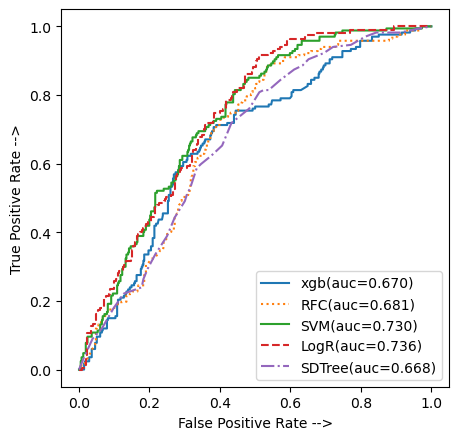

In [19]:
#Plot AUC
xgb_fpr, xgb_tpr, threshold = metrics.roc_curve(y, prob_test_final_XGB, pos_label=2)
RFC_fpr, RFC_tpr, threshold = metrics.roc_curve(y, prob_test_final_RFC, pos_label=2)
SVM_fpr, SVM_tpr, threshold = metrics.roc_curve(y, prob_test_final_SVM, pos_label=2)
LogR_fpr, LogR_tpr, threshold = metrics.roc_curve(y, prob_test_final_LogR, pos_label=2)
SDTree_fpr, SDTree_tpr, threshold = metrics.roc_curve(y, prob_test_final_SDTree, pos_label=2)

auc_xgb = metrics.auc(xgb_fpr, xgb_tpr)
auc_RFC_test = metrics.auc(RFC_fpr, RFC_tpr)
auc_SVM_test = metrics.auc(SVM_fpr, SVM_tpr)
auc_LogR_test = metrics.auc(LogR_fpr, LogR_tpr)
auc_SDTree_test = metrics.auc(SDTree_fpr, SDTree_tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, linestyle='-', label='xgb(auc=%0.3f)' % auc_xgb)
plt.plot(RFC_fpr, RFC_tpr, linestyle='dotted', label='RFC(auc=%0.3f)' % auc_RFC_test)
plt.plot(SVM_fpr, SVM_tpr, linestyle='solid', label='SVM(auc=%0.3f)' % auc_SVM_test)
plt.plot(LogR_fpr, LogR_tpr, linestyle='dashed', label='LogR(auc=%0.3f)' % auc_LogR_test)
plt.plot(SDTree_fpr, SDTree_tpr, linestyle='dashdot', label='SDTree(auc=%0.3f)' % auc_SDTree_test)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()